# MIDI music generation with GAN

Notebook presented for the A.A. 2023/2024 Deep Learning project.

Daniel Capannini - daniel.capannini@studio.unibo.it

In this notebook, GANs with different sized structures will be compared and the results obtained will be compared.

---

Below is the download of the dataset and installation of the libraries used.

In [ ]:
!pip install miditok
!pip install pretty_midi
!pip install -q gdown
!pip install mido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 40.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=797678d4084b1bf28c80c4d1434acafa5c5ee635fa8cdd1bd2e69dae4efa2ca7
  Stored in directory: /root/.cache/pip/wheels/a4/f9/9e/08350c27e386558df0ae234e28a8facd145ba45506ddd1b989
Successfully built pretty_midi


In [ ]:
import os
import shutil
from pathlib import Path
import numpy as np
from IPython.display import Audio, display
from miditok import REMI, TokenizerConfig
from pathlib import Path
from miditok.data_augmentation import augment_dataset
from miditok.utils import split_files_for_training
from random import shuffle
import json
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pretty_midi
import matplotlib.pyplot as plt
import glob
import mido
from collections import Counter
from scipy.special import rel_entr

## dataset

the dataset used is [MAESTRO dataset](https://magenta.withgoogle.com/datasets/maestro), which contains a collection of MIDIs from different piano performances.

New folder is created with all the MIDI files of the dataset.

In [ ]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
!unzip 'maestro-v3.0.0-midi.zip'
!rm 'maestro-v3.0.0-midi.zip'
dataset_path = "maestro-v3.0.0"

--2025-09-09 14:59:47--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.207, 173.194.217.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip’

maestro-v3.0.0-midi 100%[===================>]  55.71M   200MB/s    in 0.3s    

2025-09-09 14:59:47 (200 MB/s) - ‘maestro-v3.0.0-midi.zip’ saved [58416533/58416533]

Archive:  maestro-v3.0.0-midi.zip
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_01_Track01_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_T

In [ ]:
destination_folder = "dataset_midi"
os.makedirs(destination_folder, exist_ok=True)

midi_paths = list(Path(dataset_path).resolve().glob("**/*.mid")) + \
             list(Path(dataset_path).resolve().glob("**/*.midi"))

print(f"Trovati {len(midi_paths)} file MIDI.")

for midi_path in midi_paths:
    filename = os.path.basename(midi_path)
    destination_path = os.path.join(destination_folder, filename)
    shutil.copy2(midi_path, destination_path)

print("Copia completata in 'dataset_midi'.")

midi_paths = [Path(os.path.join(destination_folder, os.path.basename(p))) for p in midi_paths]

Trovati 1276 file MIDI.
Copia completata in 'dataset_midi'.


## Data Analisis

A MIDI (Musical Instrument Digital Interface) file is a digital file format that stores instructions for playing music rather than the actual audio itself. Instead of containing recorded sound, a MIDI file includes data such as which notes are played, their duration, pitch, intensity, and the instruments to be used. This makes MIDI files very lightweight and versatile, as they can be played back on different devices and instruments, often sounding different depending on the sound library or synthesizer used.

Estimated time: 199.94214636968422


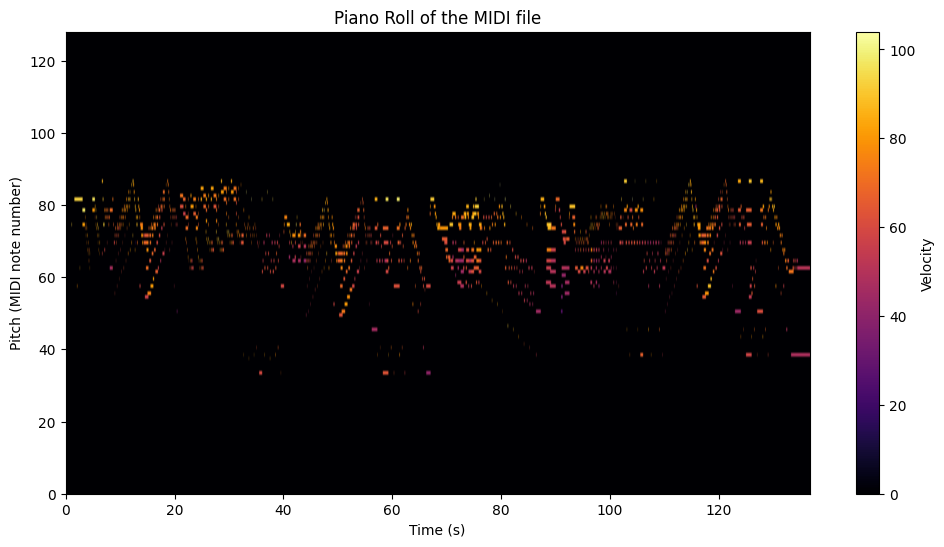

In [ ]:
midi = pretty_midi.PrettyMIDI("/content/dataset_midi/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.midi")

print("Estimated time:", midi.estimate_tempo())

fs = 100
piano_roll = midi.get_piano_roll(fs=fs)

plt.figure(figsize=(12, 6))
plt.imshow(piano_roll[::-1], aspect='auto', cmap='inferno',
           extent=[0, piano_roll.shape[1]/fs, 0, 128])
plt.xlabel("Time (s)")
plt.ylabel("Pitch (MIDI note number)")
plt.title("Piano Roll of the MIDI file")
plt.colorbar(label="Velocity")
plt.show()


## Tokenizzazione

MIDI was not used directly for training, but was first tokenized using a tokenizer, which was trained below.

A tokenizer is a tool that converts raw MIDI data into a sequence of tokens that the AI ​​model can understand.

In the context of MIDI tokenization, each token represents a specific musical element or event, such as a note, velocity, or duration. These tokens serve as a "vocabulary" for the model, allowing it to learn and generate music.

In [ ]:
BEAT_RES = {(0, 1): 12, (1, 2): 4, (2, 4): 2, (4, 8): 1}
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": BEAT_RES,
    "num_velocities": 3,
    "special_tokens": ["BOS", "EOS"],
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "num_tempos": 8,
    "tempo_range": (50, 200),
}

In [ ]:
midi_dir = Path(destination_folder)
midis = list(midi_dir.glob("**/*.mid")) + list(midi_dir.glob("**/*.midi"))

if not midis:
    raise FileNotFoundError("Nessun file MIDI trovato in 'dataset_midi'.")

Train tokenizer

In [ ]:
config = TokenizerConfig(**TOKENIZER_PARAMS)

tokenizer = REMI(config)

vocab_size = 5000
tokenizer.train(vocab_size=vocab_size, files_paths=midis)
processed = [Path(f"{s}") for s in midis]
print(len(processed))

1276


In [ ]:
tokenizer.save("tokenizerMIDI")

## download tokenizer

execute the next 2 cells to skip tokenizer training

In [ ]:
!gdown --id 12der1lMHfMyMbGWImONehL_43AoECyzB

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12der1lMHfMyMbGWImONehL_43AoECyzB
To: /content/tokenizer (2).json
100% 271k/271k [00:00<00:00, 111MB/s]


In [ ]:
tokenizer = REMI(params="tokenizer (2).json")

## Dataset preparation

organizes a MIDI dataset by collecting all MIDI files, splitting them into train/validation subsets, and then applying preprocessing steps. Specifically, it chunks the training and validation files into sequences suitable for modeling, applies data augmentation (pitch, velocity, duration variations), and finally reloads the processed files for each subset.

In [ ]:

base_dir = Path("/content/dataset_midi").resolve()

midis = list(base_dir.glob("**/*.mid")) + list(base_dir.glob("**/*.midi"))
midis = [midi.resolve() for midi in midis]

total_num_files = len(midis)
num_files_valid = round(total_num_files * 0.20)

shuffle(midis)

midi_paths_valid = midis[:num_files_valid]
midi_paths_train = midis[num_files_valid:]

# Chunk e augment
for files_paths, subset_name in (
    (midi_paths_train, "train"),
    (midi_paths_valid, "valid")
):
    subset_chunks_dir = Path(f"Maestro_{subset_name}")

    split_files_for_training(
        files_paths=files_paths,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

    augment_dataset(
        subset_chunks_dir,
        pitch_offsets=[-12, 12],
        velocity_offsets=[-3, 3],
        duration_offsets=[-0.5, 0.5],
    )

midi_paths_train = list(Path("Maestro_train").glob("**/*.mid")) + list(Path("Maestro_train").glob("**/*.midi"))
midi_paths_valid = list(Path("Maestro_valid").glob("**/*.mid")) + list(Path("Maestro_valid").glob("**/*.midi"))


Performing data augmentation: 100%|██████████| 1852/1852 [00:04<00:00, 406.03it/s]


All MIDI files from the training and validation set are tokenized so they can be used to train the GAN.

In [ ]:
def midi_valid(midi) -> bool:
    if any(ts.numerator != 4 for ts in midi.time_signature_changes):
        return False  # time signature different from 4/*, 4 beats per bar
    return True

if os.path.exists("tokenized"):
  shutil.rmtree("tokenized")

for dir in ("train", "valid"):
    tokenizer.tokenize_dataset(
        Path(f"Maestro_{dir}").resolve(),
        Path(f"tokenized_{dir}").resolve(),
        midi_valid,
    )

Tokenizing music files (content/tokenized_valid): 100%|██████████| 11162/11162 [04:41<00:00, 39.64it/s]


In [ ]:
!zip -r tokenized_train.zip tokenized_train
!zip -r tokenized_valid.zip tokenized_valid

## download the tokenized dataset

In [ ]:
!gdown --id 1Dxs6XjE7luoXGVOSajBm94q_7YWPUzxO
!gdown --id 17IECX9WdgCtMSMaSgGBBoSWH6L97CLh_

!unzip tokenized_train.zip
!unzip tokenized_valid.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: tokenized_valid/MIDI-Unprocessed_17_R2_2011_MID--AUDIO_R2-D5_03_Track03_wav_8#v3.json  
  inflating: tokenized_valid/MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_04_Track04_wav_3#p12.json  
  inflating: tokenized_valid/MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_05_WAV_0#v3.json  
  inflating: tokenized_valid/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--3_9#p12.json  
  inflating: tokenized_valid/MIDI-Unprocessed_R1_D2-21-22_mid--AUDIO-from_mp3_22_R1_2015_wav--2_5.json  
  inflating: tokenized_valid/MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_11_R1_2014_wav--3_26.json  
  inflating: tokenized_valid/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_03_Track03_wav_12#d192.json  
  inflating: tokenized_valid/MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_13_R2_2015_wav--4_2#d-240.json  
  inflating: tokenized_valid/MIDI-Unprocessed_Schubert1-3_MID--AUDIO_02

## Read JSON

Here we read the produced JSON files containing the tokenization's output.

In [ ]:
def load_json(filepath: str) -> dict:
    """Load a JSON file and return its contents."""
    try:
        with open(filepath, "r") as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Skipping {filepath}: {e}")
        return None


def load_multiple_jsons(file_paths):
    """Load multiple JSON files into a list of objects."""
    results = []
    for fp in tqdm(file_paths, desc="Reading JSON files"):
        obj = load_json(fp)
        if obj is not None:
            results.append(obj)
    return results

train_jsons = Path("tokenized_train").resolve().rglob("*.json")
valid_jsons = Path("tokenized_valid").resolve().rglob("*.json")

train_data = load_multiple_jsons(train_jsons)
valid_data = load_multiple_jsons(valid_jsons)

if train_data and valid_data:
    print(f"\nLoaded {len(train_data)} JSON files for training.")
    print(f"Loaded {len(valid_data)} JSON files for validation.")
else:
    print("Some JSON files could not be read.")


Reading JSON files: 59536it [00:12, 4898.81it/s]
Reading JSON files: 13816it [00:03, 4173.24it/s]


Loaded 59536 JSON files for training.
Loaded 13816 JSON files for validation.


Rather than padding each MIDI file (converted into tokens) to a fixed length with special padding tokens, we instead concatenate the token IDs of all piano pieces into a single large Numpy array. This approach comes with trade-offs—most notably a loss of musical coherence when sequences are passed to the model and a weaker sense of each song as a complete unit—but it provides much greater flexibility in handling and processing the dat

In [ ]:
def extract_ids(data_objects):
    """Extract and convert token IDs from JSON objects."""
    arrays = []
    for obj in data_objects:
        if "ids" in obj and isinstance(obj["ids"], list) and len(obj["ids"]) > 0:
            arrays.append(np.asarray(obj["ids"][0], dtype=np.int32))
    return np.concatenate(arrays, axis=0)

all_ids_train = extract_ids(train_data)
all_ids_valid = extract_ids(valid_data)

## GAN model

The system is based on the structure of a Generative Adversarial Network (GAN) and consists of two main components:

Generator Network: a fully connected neural network that takes a random noise vector as input and produces a MIDI file as output (Generated MIDI). The generator's objective is to create data that closely mimics authentic data. This component embodies the creative aspect of the GAN architecture.

Discriminator Network: another fully connected neural network that receives as input both authentic MIDI files (from the Maestro Dataset) and MIDI files produced by the generator. The discriminator's function is to classify these inputs as either authentic (True) or synthetic (False). This component embodies the evaluative aspect of the GAN architecture.

Training process: The generator enhances its performance by attempting to fool the discriminator, creating data that the discriminator finds progressively more challenging to distinguish from authentic data. Simultaneously, the discriminator is optimized to become more precise at identifying the distinction between authentic and generated data. This adversarial process relies on a loss function calculated for both networks, with weight updates executed using the ADAM optimizer.

To evaluate performance variation in relation to model complexity, three generators and three discriminators were trained with the same overall architecture but varying sizes:

- Mini,
- Medium,
- Large.

These models share the same fundamental architecture but differ in the number of neurons and layers, enabling a comparative analysis of their performance in relation to representational capacity.

In [ ]:
class GeneratorMini(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, output_length),
            nn.Tanh()
        )

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        return self.model(noise_vector)


class DiscriminatorMini(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_length, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, 1)
        )

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        return self.model(sequence)


In [ ]:
class GeneratorMedium(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim * 8),
            nn.ReLU(),
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, output_length),
            nn.Tanh()
        )

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        return self.model(noise_vector)


class DiscriminatorMedium(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_length, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 8, 1)
        )

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        return self.model(sequence)


In [ ]:
class GeneratorLarge(nn.Module):
    def __init__(self, noise_dim: int, hidden_dim: int, output_length: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim * 16),
            nn.ReLU(),
            nn.Linear(hidden_dim * 16, hidden_dim * 8),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, output_length),
            nn.Tanh()
        )

    def forward(self, noise_vector: torch.Tensor) -> torch.Tensor:
        return self.model(noise_vector)


class DiscriminatorLarge(nn.Module):
    def __init__(self, input_length: int, hidden_dim: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_length, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 8, hidden_dim * 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 16, 1)
        )

    def forward(self, sequence: torch.Tensor) -> torch.Tensor:
        return self.model(sequence)


Hyper-parameters kept unchanged for training each model

In [ ]:
vocab_size = len(tokenizer)
seq_length = 512
noise_dim = 512
hidden_dim = 1536
batch_size = 128

generator_config = {
    "noise_dim"  : noise_dim,
    "hidden_dim" : hidden_dim,
    "output_length" : seq_length
}


discriminator_config = {
    "input_length" : seq_length,
    "hidden_dim" : hidden_dim
}

## GAN class

This GAN class implements the logic required to train a Generative Adversarial Network (GAN) composed of a generator and a discriminator. Both models are passed as arguments to the constructor, along with the input noise size, the length of the musical sequence, and the tokenizer used to manage the MIDI data. The class independently manages the optimizers, weight initialization, and loss function calculation, allowing the two models to be trained in a coordinated manner.

During training, the discriminator learns to distinguish between real MIDI files (from the dataset) and those generated by the generator, while the generator attempts to produce increasingly convincing sequences capable of fooling the discriminator. The class also manages alternating training strategies to balance the update steps of the two models and includes checks to avoid numerical instabilities such as NaN or Inf values. It also provides methods to save the weights of the trained models, generate new sequences as numeric arrays, and convert them into real MIDI files, ready to be listened to and analyzed.

In [ ]:
class MidiGAN:
    def __init__(
        self,
        generator: nn.Module,
        discriminator: nn.Module,
        noise_dim: int,
        sequence_length: int,
        tokenizer,
        loss_fn: nn.Module = nn.BCEWithLogitsLoss(),
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.noise_dim = noise_dim
        self.sequence_length = sequence_length
        self.loss_fn = loss_fn
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer)

        self.generator_optimizer = torch.optim.Adam(
            self.generator.parameters(), lr=0.00005, betas=(0.5, 0.999)
        )
        self.discriminator_optimizer = torch.optim.Adam(
            self.discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999)
        )

        self.generator.apply(self._init_weights)
        self.discriminator.apply(self._init_weights)

    def save(self, filepath: str):
        """Save the whole MidiGAN instance to disk."""
        torch.save(self, filepath)
        print(f"MidiGAN saved to {filepath}")

    @staticmethod
    def load(filepath: str, map_location: str = "cpu"):
        """Load a previously saved MidiGAN instance."""
        gan = torch.load(filepath, map_location=map_location)
        if not isinstance(gan, MidiGAN):
            raise TypeError("The loaded object is not a MidiGAN instance.")
        print(f"MidiGAN loaded from {filepath}")
        return gan


    def train(
        self,
        dataloader,
        epochs: int,
        device: torch.device,
        loss_delta: float = 0.7,
        steps_each_print: int = 5,
        advantage_steps: int = 2,
        alternate_training: bool = False,
        generator_steps: int = 1,
        discriminator_steps: int = 1,
    ):
        """
        Train the GAN on a dataloader.
        """
        print(f"Starting training for {epochs} epochs")
        self.generator.to(device).train()
        self.discriminator.to(device).train()

        all_d_losses = []
        all_g_losses = []

        for epoch in range(epochs):
            pbar = tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}")
            for step, real_batch in enumerate(dataloader):
                batch_size = real_batch.size(0)
                real_batch = real_batch.to(device)

                d_loss, g_loss = self._train_batch(
                    batch_size, real_batch, device, generator_steps, discriminator_steps
                )
                all_d_losses.append(d_loss)
                all_g_losses.append(g_loss)

                if alternate_training:
                    if g_loss - d_loss > loss_delta:
                        generator_steps, discriminator_steps = advantage_steps, 1
                    elif d_loss - g_loss > loss_delta:
                        discriminator_steps, generator_steps = advantage_steps, 1
                    else:
                        generator_steps, discriminator_steps = 1, 1

                if (step + 1) % steps_each_print == 0:
                    desc = f"D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}"
                    if generator_steps != 1 or discriminator_steps != 1:
                        desc += f" | D Steps: {discriminator_steps}, G Steps: {generator_steps}"
                    pbar.set_description(desc)
                pbar.update(1)

            pbar.close()
            print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

        return all_d_losses, all_g_losses

    def _generator_train_step(self, batch_size: int, device: torch.device) -> float:
        """Perform one training step for the generator."""
        self.generator.zero_grad()

        noise = self._sample_noise(batch_size, device)
        fake_data = self.generator(noise)
        fake_predictions = self.discriminator(fake_data)

        loss_g = -torch.mean(fake_predictions)

        if not (torch.isnan(loss_g) or torch.isinf(loss_g)):
            loss_g.backward()
            torch.nn.utils.clip_grad_norm_(self.generator.parameters(), max_norm=1.0)
            self.generator_optimizer.step()
        else:
            print("NaN or Inf detected in generator loss.")

        return loss_g.item()

    def _discriminator_train_step(
        self, batch_size: int, real_data: torch.Tensor, device: torch.device
    ) -> float:
        """Perform one training step for the discriminator."""
        self.discriminator.zero_grad()

        noise = self._sample_noise(batch_size, device)
        fake_data = self.generator(noise)

        real_predictions = self.discriminator(real_data)
        fake_predictions = self.discriminator(fake_data)

        real_labels = torch.ones_like(real_predictions)
        fake_labels = torch.zeros_like(fake_predictions)

        loss_real = self.loss_fn(real_predictions, real_labels)
        loss_fake = self.loss_fn(fake_predictions, fake_labels)

        loss_d = loss_real + loss_fake

        if not (torch.isnan(loss_d) or torch.isinf(loss_d)):
            loss_d.backward()
            self.discriminator_optimizer.step()
        else:
            print("NaN or Inf detected in discriminator loss.")

        return loss_d.item()

    def _init_weights(self, layer):
        """Initialize weights for linear and conv1d layers."""
        if isinstance(layer, (nn.Linear, nn.Conv1d)):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def _sample_noise(self, batch_size: int, device: torch.device) -> torch.Tensor:
        """Generate random noise as input for the generator."""
        return torch.randn(batch_size, self.noise_dim, device=device)

    def _train_batch(
        self, batch_size: int, real_data: torch.Tensor, device: torch.device,
        generator_steps: int, discriminator_steps: int
    ):
        """Run one batch of training alternating generator and discriminator."""
        discriminator_losses = [
            self._discriminator_train_step(batch_size, real_data, device)
            for _ in range(discriminator_steps)
        ]
        generator_losses = [
            self._generator_train_step(batch_size, device)
            for _ in range(generator_steps)
        ]
        return np.mean(discriminator_losses), np.mean(generator_losses)

    def predict(self, n_samples: int, device: torch.device):
        """Generate output from the generator as NumPy arrays."""
        noise = self._sample_noise(n_samples, device)
        return self.generator(noise).cpu().detach().numpy()

    def generate_midi(self, n_samples: int, output_prefix: str, device: torch.device):
        """Generate and save MIDI files from the generator output."""
        predictions = self.predict(n_samples, device)
        midpoint = self.vocab_size // 2
        predictions = [x * midpoint + midpoint for x in predictions]

        for i, pred in enumerate(predictions):
            pred_tokens = pred.astype(np.int32)
            pred_tokens[pred_tokens == self.vocab_size] = 0
            try:
                decoded = self.tokenizer.decode([pred_tokens])
                decoded.dump_midi(f"{output_prefix}_{i}.mid")
            except Exception as e:
                print(f"Error in MIDI generation: {e}")


The TokenDataset class and the normalize_data function prepare the input data for GAN training. Specifically, TokenDataset defines a custom dataset containing token sequences (derived from the MIDI file) and makes them compatible with PyTorch, returning 32-bit floating-point numeric tensors, ready for use in data loaders. The normalize_data function, on the other hand, normalizes the token values ​​to a range between -1 and 1, so they better fit the generator's widely used activation function. This normalization step is crucial because it ensures numerical stability and speeds up convergence during training, reducing the risk of gradients that are too large or too small.

In [ ]:
class TokenDataset(Dataset):
    """Dataset of normalized token sequences for GAN training."""
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32)


def normalize_data(token_array, vocab_size: int):
    """
    Normalize input data to a interval = (-1, 1).
    """
    min_val, max_val = (-1, 1)
    normalized = (token_array - vocab_size / 2) / (vocab_size / 2)
    scaled = normalized * (max_val - min_val) / 2 + (max_val + min_val) / 2
    return scaled


## Trainig GAN Mini

## Setup for training

It then initializes the GAN generator and discriminator, configures the computing device (CPU or GPU), and prepares the data for training. Specifically, the MIDI tokens are normalized to the range
−1, 1, split into sequences of the desired length, and organized into a PyTorch dataset managed by DataLoader, which handles batching and shuffling. Finally, a quick test is performed on the GPU and the dataset information is printed to confirm that the system is ready for training.

This operation is also performed for training the other models.

In [ ]:
generator = GeneratorMini(**generator_config)
discriminator = DiscriminatorMini(**discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "sequence_length"          : seq_length,
    "tokenizer"                : tokenizer,
}


# ===============================
# PARAMETERS
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0) if torch.cuda.is_available() else None

sequence_length = seq_length  # taken from general configuration
batch_size = batch_size       # keep existing value

# ===============================
# DATA PREPARATION
# ===============================
vocab_size = len(tokenizer)
normalized_tokens = normalize_data(all_ids_train, vocab_size)

print(f"Normalization completed | Max: {normalized_tokens.max():.4f}, Min: {normalized_tokens.min():.4f}")

# Create sequences of the required length
sequences = [
    normalized_tokens[i : i + sequence_length]
    for i in range(0, len(normalized_tokens) - sequence_length, sequence_length)
]

# Dataset and DataLoader
dataset = TokenDataset(sequences)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4
)

# Quick GPU test
_ = torch.ones(1, device=device)
print(f"Dataset ready. Batch size: {batch_size}, Number of batches: {len(dataloader)}")


Normalization completed | Max: 0.9996, Min: -0.9988
Dataset ready. Batch size: 128, Number of batches: 921


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
gan_mini = GAN(**gan_params)

training_arguments = {
    "dataloader"            : dataloader,
    "epochs"                : 45,
    "device"                : device,
    "steps_each_print"      : 10,
    "generator_steps"       : 1,
    "discriminator_steps"   : 1,
}

losses_discriminator, losses_generator = gan_mini.train(**training_arguments)

Starting training for 45 epochs


D Loss: 1.1770, G Loss: 0.9220: 100%|██████████| 921/921 [00:41<00:00, 22.16it/s]


Epoch 1/45 | D Loss: 1.2622 | G Loss: 1.9872


D Loss: 1.0706, G Loss: 2.4450: 100%|██████████| 921/921 [00:42<00:00, 21.85it/s]


Epoch 2/45 | D Loss: 1.1167 | G Loss: 0.3430


D Loss: 0.7179, G Loss: 1.6720: 100%|██████████| 921/921 [00:41<00:00, 22.44it/s]


Epoch 3/45 | D Loss: 0.7158 | G Loss: 3.4905


D Loss: 1.5358, G Loss: -0.1144: 100%|██████████| 921/921 [00:40<00:00, 22.47it/s]


Epoch 4/45 | D Loss: 1.5449 | G Loss: -0.0989


D Loss: 1.4004, G Loss: 0.0994: 100%|██████████| 921/921 [00:40<00:00, 22.54it/s]


Epoch 5/45 | D Loss: 1.4063 | G Loss: 0.1453


D Loss: 1.2583, G Loss: 1.1348: 100%|██████████| 921/921 [00:40<00:00, 22.59it/s]


Epoch 6/45 | D Loss: 1.2208 | G Loss: 1.0895


D Loss: 0.7908, G Loss: 1.7645: 100%|██████████| 921/921 [00:41<00:00, 22.45it/s]


Epoch 7/45 | D Loss: 0.8547 | G Loss: 2.5375


D Loss: 1.3932, G Loss: 1.0424: 100%|██████████| 921/921 [00:40<00:00, 22.55it/s]


Epoch 8/45 | D Loss: 1.3682 | G Loss: 1.3361


D Loss: 1.0788, G Loss: 0.5456: 100%|██████████| 921/921 [00:40<00:00, 22.51it/s]


Epoch 9/45 | D Loss: 1.1763 | G Loss: 1.8759


D Loss: 0.9450, G Loss: 0.9203: 100%|██████████| 921/921 [00:41<00:00, 22.36it/s]


Epoch 10/45 | D Loss: 0.9953 | G Loss: 1.8724


D Loss: 1.0186, G Loss: 0.7684: 100%|██████████| 921/921 [00:41<00:00, 22.39it/s]


Epoch 11/45 | D Loss: 1.0091 | G Loss: 1.6122


D Loss: 0.9105, G Loss: 1.2329: 100%|██████████| 921/921 [00:40<00:00, 22.51it/s]


Epoch 12/45 | D Loss: 0.7485 | G Loss: 2.4639


D Loss: 0.8454, G Loss: 1.9436: 100%|██████████| 921/921 [00:40<00:00, 22.47it/s]


Epoch 13/45 | D Loss: 0.7773 | G Loss: 1.7205


D Loss: 0.6537, G Loss: 2.6350: 100%|██████████| 921/921 [00:41<00:00, 22.41it/s]


Epoch 14/45 | D Loss: 0.7422 | G Loss: 1.8194


D Loss: 0.7498, G Loss: 4.2639: 100%|██████████| 921/921 [00:40<00:00, 22.48it/s]


Epoch 15/45 | D Loss: 0.9512 | G Loss: 0.7331


D Loss: 0.8374, G Loss: 2.4344: 100%|██████████| 921/921 [00:40<00:00, 22.49it/s]


Epoch 16/45 | D Loss: 0.8974 | G Loss: 1.7452


D Loss: 0.9663, G Loss: 3.0039: 100%|██████████| 921/921 [00:41<00:00, 22.42it/s]


Epoch 17/45 | D Loss: 0.8168 | G Loss: 1.7060


D Loss: 1.1542, G Loss: 2.5561: 100%|██████████| 921/921 [00:41<00:00, 22.36it/s]


Epoch 18/45 | D Loss: 1.1777 | G Loss: 0.4486


D Loss: 0.9845, G Loss: 1.2860: 100%|██████████| 921/921 [00:40<00:00, 22.49it/s]


Epoch 19/45 | D Loss: 1.0437 | G Loss: 2.6605


D Loss: 0.8085, G Loss: 1.9472: 100%|██████████| 921/921 [00:41<00:00, 22.44it/s]


Epoch 20/45 | D Loss: 0.8428 | G Loss: 2.6235


D Loss: 0.9703, G Loss: 2.9681: 100%|██████████| 921/921 [00:41<00:00, 22.39it/s]


Epoch 21/45 | D Loss: 1.0419 | G Loss: 0.9280


D Loss: 0.6979, G Loss: 2.5483: 100%|██████████| 921/921 [00:41<00:00, 22.41it/s]


Epoch 22/45 | D Loss: 0.6557 | G Loss: 2.3710


D Loss: 0.6890, G Loss: 1.4612: 100%|██████████| 921/921 [00:41<00:00, 22.45it/s]


Epoch 23/45 | D Loss: 0.7621 | G Loss: 2.8933


D Loss: 0.7380, G Loss: 2.4777: 100%|██████████| 921/921 [00:41<00:00, 22.33it/s]


Epoch 24/45 | D Loss: 0.7405 | G Loss: 2.4546


D Loss: 1.1137, G Loss: 1.7862: 100%|██████████| 921/921 [00:41<00:00, 22.41it/s]


Epoch 25/45 | D Loss: 1.0560 | G Loss: 1.2323


D Loss: 0.8083, G Loss: 2.0905: 100%|██████████| 921/921 [00:40<00:00, 22.49it/s]


Epoch 26/45 | D Loss: 0.9130 | G Loss: 1.5355


D Loss: 0.6560, G Loss: 3.1079: 100%|██████████| 921/921 [00:41<00:00, 22.46it/s]


Epoch 27/45 | D Loss: 0.7552 | G Loss: 1.0452


D Loss: 0.7931, G Loss: 1.0786: 100%|██████████| 921/921 [00:41<00:00, 22.40it/s]


Epoch 28/45 | D Loss: 1.0178 | G Loss: 4.8992


D Loss: 0.9182, G Loss: 1.4399: 100%|██████████| 921/921 [00:41<00:00, 22.38it/s]


Epoch 29/45 | D Loss: 0.8879 | G Loss: 2.1540


D Loss: 0.9197, G Loss: 1.5940: 100%|██████████| 921/921 [00:40<00:00, 22.52it/s]


Epoch 30/45 | D Loss: 0.8623 | G Loss: 1.8841


D Loss: 0.7731, G Loss: 1.1615: 100%|██████████| 921/921 [00:40<00:00, 22.49it/s]


Epoch 31/45 | D Loss: 0.9650 | G Loss: 2.9012


D Loss: 0.9309, G Loss: 2.8883: 100%|██████████| 921/921 [00:41<00:00, 22.42it/s]


Epoch 32/45 | D Loss: 0.9262 | G Loss: 0.4029


D Loss: 1.1144, G Loss: 1.2955: 100%|██████████| 921/921 [00:40<00:00, 22.47it/s]


Epoch 33/45 | D Loss: 0.8596 | G Loss: 2.0001


D Loss: 1.0645, G Loss: 1.9013: 100%|██████████| 921/921 [00:40<00:00, 22.57it/s]


Epoch 34/45 | D Loss: 0.9517 | G Loss: 2.1912


D Loss: 0.9384, G Loss: 1.7416: 100%|██████████| 921/921 [00:40<00:00, 22.53it/s]


Epoch 35/45 | D Loss: 0.8282 | G Loss: 2.7450


D Loss: 1.0032, G Loss: 1.2606: 100%|██████████| 921/921 [00:40<00:00, 22.48it/s]


Epoch 36/45 | D Loss: 1.0626 | G Loss: 2.2287


D Loss: 1.1196, G Loss: 0.9579: 100%|██████████| 921/921 [00:40<00:00, 22.54it/s]


Epoch 37/45 | D Loss: 1.0110 | G Loss: 2.2813


D Loss: 1.2865, G Loss: 1.3274: 100%|██████████| 921/921 [00:40<00:00, 22.55it/s]


Epoch 38/45 | D Loss: 1.1346 | G Loss: 1.3536


D Loss: 1.0021, G Loss: 1.1490: 100%|██████████| 921/921 [00:40<00:00, 22.53it/s]


Epoch 39/45 | D Loss: 0.9891 | G Loss: 1.0138


D Loss: 1.2610, G Loss: 2.3503: 100%|██████████| 921/921 [00:41<00:00, 22.43it/s]


Epoch 40/45 | D Loss: 1.1139 | G Loss: 0.7495


D Loss: 1.0444, G Loss: 1.1662: 100%|██████████| 921/921 [00:40<00:00, 22.54it/s]


Epoch 41/45 | D Loss: 0.9765 | G Loss: 1.9463


D Loss: 1.0362, G Loss: 1.7037: 100%|██████████| 921/921 [00:40<00:00, 22.54it/s]


Epoch 42/45 | D Loss: 1.1313 | G Loss: 0.8161


D Loss: 1.2370, G Loss: 2.1538: 100%|██████████| 921/921 [00:41<00:00, 22.44it/s]


Epoch 43/45 | D Loss: 1.3232 | G Loss: 0.1855


D Loss: 0.9748, G Loss: 1.3247: 100%|██████████| 921/921 [00:40<00:00, 22.47it/s]


Epoch 44/45 | D Loss: 0.9986 | G Loss: 1.1361


D Loss: 1.0643, G Loss: 0.7795: 100%|██████████| 921/921 [00:40<00:00, 22.58it/s]

Epoch 45/45 | D Loss: 1.0518 | G Loss: 1.5915


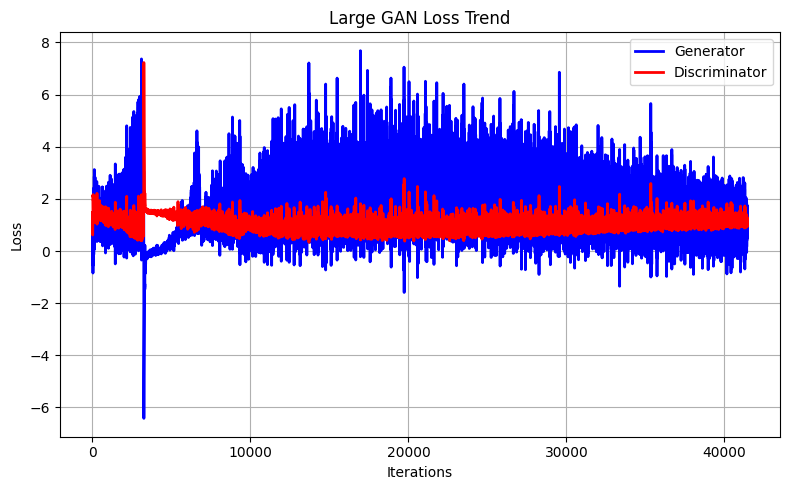

In [ ]:

iterations = list(range(1, len(losses_discriminator) + 1))

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generator", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminator", color="red", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Large GAN Loss Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gan_mini.save("gan_mini.pth")

generator_mini = generator
discriminator_mini = discriminator

## Trainig GAN Medium

In [ ]:
generator = GeneratorMedium(**generator_config)
discriminator = DiscriminatorMedium(**discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "sequence_length"          : seq_length,
    "tokenizer"                : tokenizer,
}


# ===============================
# PARAMETRI
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0) if torch.cuda.is_available() else None

sequence_length = seq_length  # preso dalla configurazione generale
batch_size = batch_size       # manteniamo il valore esistente

# ===============================
# PREPARAZIONE DATI
# ===============================
vocab_size = len(tokenizer)
normalized_tokens = normalize_data(all_ids_train, vocab_size)

print(f"Normalizzazione completata | Max: {normalized_tokens.max():.4f}, Min: {normalized_tokens.min():.4f}")

# Creiamo sequenze della lunghezza richiesta
sequences = [
    normalized_tokens[i : i + sequence_length]
    for i in range(0, len(normalized_tokens) - sequence_length, sequence_length)
]

# Dataset e DataLoader
dataset = TokenDataset(sequences)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4
)

# Test rapido GPU
_ = torch.ones(1, device=device)
print(f"Dataset pronto. Batch size: {batch_size}, Numero batch: {len(dataloader)}")

Normalizzazione completata | Max: 0.9996, Min: -0.9988
Dataset pronto. Batch size: 128, Numero batch: 921


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
gan_medium = GAN(**gan_params)

training_arguments = {
    "dataloader"            : dataloader,
    "epochs"                : 45,
    "device"                : device,
    "steps_each_print"      : 10,
    "generator_steps"       : 1,
    "discriminator_steps"   : 1,
}

losses_discriminator, losses_generator = gan_medium.train(**training_arguments)

Starting training for 45 epochs


Epoch 1/45:   0%|          | 0/921 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
D Loss: 1.3067, G Loss: 0.6804: 100%|██████████| 921/921 [02:39<00:00,  5.77it/s]


Epoch 1/45 | D Loss: 1.2259 | G Loss: 1.7961


D Loss: 0.2369, G Loss: 3.3939: 100%|██████████| 921/921 [02:47<00:00,  5.50it/s]


Epoch 2/45 | D Loss: 0.1888 | G Loss: 4.0276


D Loss: 0.0268, G Loss: 6.4686: 100%|██████████| 921/921 [02:47<00:00,  5.50it/s]


Epoch 3/45 | D Loss: 0.0649 | G Loss: 5.2190


D Loss: 1.4951, G Loss: -0.2367: 100%|██████████| 921/921 [02:46<00:00,  5.52it/s]


Epoch 4/45 | D Loss: 1.5134 | G Loss: -0.2663


D Loss: 1.4032, G Loss: 0.0363: 100%|██████████| 921/921 [02:44<00:00,  5.60it/s]


Epoch 5/45 | D Loss: 1.3990 | G Loss: 0.0522


D Loss: 1.6189, G Loss: -0.0663: 100%|██████████| 921/921 [02:44<00:00,  5.59it/s]


Epoch 6/45 | D Loss: 1.9458 | G Loss: 3.1320


D Loss: 0.0747, G Loss: 4.6091: 100%|██████████| 921/921 [02:44<00:00,  5.58it/s]


Epoch 7/45 | D Loss: 0.0917 | G Loss: 5.4958


D Loss: 1.9739, G Loss: -0.2623: 100%|██████████| 921/921 [02:45<00:00,  5.58it/s]


Epoch 8/45 | D Loss: 2.0091 | G Loss: -0.1306


D Loss: 1.3433, G Loss: 0.1928: 100%|██████████| 921/921 [02:45<00:00,  5.58it/s]


Epoch 9/45 | D Loss: 1.3511 | G Loss: 0.1847


D Loss: 0.4967, G Loss: 3.5078: 100%|██████████| 921/921 [02:46<00:00,  5.53it/s]


Epoch 10/45 | D Loss: 0.4584 | G Loss: 4.8498


D Loss: 0.2647, G Loss: 5.1884: 100%|██████████| 921/921 [02:46<00:00,  5.53it/s]


Epoch 11/45 | D Loss: 0.2837 | G Loss: 6.3841


D Loss: 0.4721, G Loss: 4.7538: 100%|██████████| 921/921 [02:46<00:00,  5.54it/s]


Epoch 12/45 | D Loss: 0.6649 | G Loss: 2.5016


D Loss: 0.6696, G Loss: 2.6119: 100%|██████████| 921/921 [02:46<00:00,  5.54it/s]


Epoch 13/45 | D Loss: 0.7720 | G Loss: 6.4690


D Loss: 1.1125, G Loss: 9.9852: 100%|██████████| 921/921 [02:46<00:00,  5.55it/s]


Epoch 14/45 | D Loss: 1.8665 | G Loss: -0.4614


D Loss: 0.7012, G Loss: 4.4663: 100%|██████████| 921/921 [02:46<00:00,  5.53it/s]


Epoch 15/45 | D Loss: 0.6523 | G Loss: 2.6192


D Loss: 0.6547, G Loss: 6.8603: 100%|██████████| 921/921 [02:46<00:00,  5.53it/s]


Epoch 16/45 | D Loss: 0.7729 | G Loss: 1.0150


D Loss: 0.7960, G Loss: 4.8890: 100%|██████████| 921/921 [02:46<00:00,  5.55it/s]


Epoch 17/45 | D Loss: 0.7825 | G Loss: 1.6063


D Loss: 0.8434, G Loss: 5.6089: 100%|██████████| 921/921 [02:46<00:00,  5.53it/s]


Epoch 18/45 | D Loss: 0.8203 | G Loss: 2.0067


D Loss: 0.9347, G Loss: 2.5146: 100%|██████████| 921/921 [02:46<00:00,  5.55it/s]


Epoch 19/45 | D Loss: 0.9923 | G Loss: 3.5447


D Loss: 0.6391, G Loss: 3.7906: 100%|██████████| 921/921 [02:45<00:00,  5.55it/s]


Epoch 20/45 | D Loss: 0.6236 | G Loss: 3.2950


D Loss: 0.9179, G Loss: 2.1523: 100%|██████████| 921/921 [02:46<00:00,  5.55it/s]


Epoch 21/45 | D Loss: 0.9335 | G Loss: 2.9865


D Loss: 0.8813, G Loss: 2.1241: 100%|██████████| 921/921 [02:45<00:00,  5.55it/s]


Epoch 22/45 | D Loss: 0.9440 | G Loss: 2.0672


D Loss: 1.4912, G Loss: 3.8528: 100%|██████████| 921/921 [02:45<00:00,  5.56it/s]


Epoch 23/45 | D Loss: 1.5611 | G Loss: -0.0206


D Loss: 0.9724, G Loss: 1.6140: 100%|██████████| 921/921 [02:45<00:00,  5.56it/s]


Epoch 24/45 | D Loss: 0.8293 | G Loss: 2.3873


D Loss: 1.0606, G Loss: 2.8041: 100%|██████████| 921/921 [02:45<00:00,  5.56it/s]


Epoch 25/45 | D Loss: 1.0791 | G Loss: 0.5018


D Loss: 1.1750, G Loss: 1.3889: 100%|██████████| 921/921 [02:45<00:00,  5.56it/s]


Epoch 26/45 | D Loss: 1.0828 | G Loss: 1.5485


D Loss: 1.3173, G Loss: 3.8220: 100%|██████████| 921/921 [02:45<00:00,  5.57it/s]


Epoch 27/45 | D Loss: 1.3197 | G Loss: -0.3948


D Loss: 1.1132, G Loss: 1.2078: 100%|██████████| 921/921 [02:45<00:00,  5.57it/s]


Epoch 28/45 | D Loss: 1.1795 | G Loss: 1.0412


D Loss: 1.2519, G Loss: 0.8884: 100%|██████████| 921/921 [02:45<00:00,  5.57it/s]


Epoch 29/45 | D Loss: 1.2046 | G Loss: 1.2795


D Loss: 1.1967, G Loss: 0.9968: 100%|██████████| 921/921 [02:45<00:00,  5.57it/s]


Epoch 30/45 | D Loss: 1.1985 | G Loss: 1.0661


D Loss: 1.1720, G Loss: 0.0373: 100%|██████████| 921/921 [02:45<00:00,  5.57it/s]


Epoch 31/45 | D Loss: 1.3122 | G Loss: 3.0519


D Loss: 1.1884, G Loss: 1.2504: 100%|██████████| 921/921 [02:45<00:00,  5.58it/s]


Epoch 32/45 | D Loss: 1.1748 | G Loss: 0.9764


D Loss: 1.1748, G Loss: 1.1150: 100%|██████████| 921/921 [02:45<00:00,  5.58it/s]


Epoch 33/45 | D Loss: 1.2505 | G Loss: 0.7229


D Loss: 1.0414, G Loss: 0.8733: 100%|██████████| 921/921 [02:45<00:00,  5.58it/s]


Epoch 34/45 | D Loss: 1.1175 | G Loss: 1.5911


D Loss: 1.4042, G Loss: -0.1498: 100%|██████████| 921/921 [02:45<00:00,  5.58it/s]


Epoch 35/45 | D Loss: 1.4234 | G Loss: 1.1489


D Loss: 1.3181, G Loss: 1.2342: 100%|██████████| 921/921 [02:45<00:00,  5.57it/s]


Epoch 36/45 | D Loss: 1.2166 | G Loss: 0.8862


D Loss: 1.2549, G Loss: 1.7798: 100%|██████████| 921/921 [02:45<00:00,  5.57it/s]


Epoch 37/45 | D Loss: 1.1666 | G Loss: 0.0191


D Loss: 1.2192, G Loss: 0.7617: 100%|██████████| 921/921 [02:45<00:00,  5.57it/s]


Epoch 38/45 | D Loss: 1.2114 | G Loss: 0.1925


D Loss: 1.1574, G Loss: 0.9042: 100%|██████████| 921/921 [02:45<00:00,  5.57it/s]


Epoch 39/45 | D Loss: 1.1490 | G Loss: 0.6310


D Loss: 1.4587, G Loss: 2.0169: 100%|██████████| 921/921 [02:45<00:00,  5.58it/s]


Epoch 40/45 | D Loss: 1.6289 | G Loss: -0.6119


D Loss: 1.3027, G Loss: 0.3141: 100%|██████████| 921/921 [02:44<00:00,  5.58it/s]


Epoch 41/45 | D Loss: 1.3053 | G Loss: 0.5021


D Loss: 1.1514, G Loss: 0.4727: 100%|██████████| 921/921 [02:45<00:00,  5.58it/s]


Epoch 42/45 | D Loss: 1.1169 | G Loss: 0.6937


D Loss: 1.3221, G Loss: 0.3396: 100%|██████████| 921/921 [02:44<00:00,  5.58it/s]


Epoch 43/45 | D Loss: 1.2985 | G Loss: 0.3638


D Loss: 1.2530, G Loss: 0.4459: 100%|██████████| 921/921 [02:45<00:00,  5.58it/s]


Epoch 44/45 | D Loss: 1.2142 | G Loss: 0.4327


D Loss: 1.2775, G Loss: 0.3274: 100%|██████████| 921/921 [02:45<00:00,  5.58it/s]

Epoch 45/45 | D Loss: 1.1787 | G Loss: 0.4432


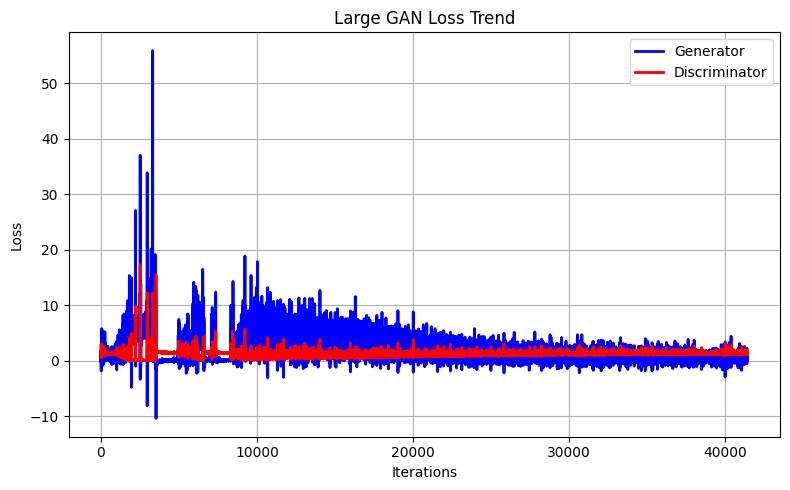

In [ ]:

iterations = list(range(1, len(losses_discriminator) + 1))

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generator", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminator", color="red", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Large GAN Loss Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gan_medium.save("gan_medium.pth")

generator_medium = generator
discriminator_medium = discriminator

## Trainig GAN Large

In [ ]:
generator = GeneratorLarge(**generator_config)
discriminator = DiscriminatorLarge(**discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "sequence_length"          : seq_length,
    "tokenizer"                : tokenizer,
}


# ===============================
# PARAMETRI
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0) if torch.cuda.is_available() else None

sequence_length = seq_length  # preso dalla configurazione generale
batch_size = batch_size       # manteniamo il valore esistente

# ===============================
# PREPARAZIONE DATI
# ===============================
vocab_size = len(tokenizer)
normalized_tokens = normalize_data(all_ids_train, vocab_size)

print(f"Normalizzazione completata | Max: {normalized_tokens.max():.4f}, Min: {normalized_tokens.min():.4f}")

# Creiamo sequenze della lunghezza richiesta
sequences = [
    normalized_tokens[i : i + sequence_length]
    for i in range(0, len(normalized_tokens) - sequence_length, sequence_length)
]

# Dataset e DataLoader
dataset = TokenDataset(sequences)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4
)

# Test rapido GPU
_ = torch.ones(1, device=device)
print(f"Dataset pronto. Batch size: {batch_size}, Numero batch: {len(dataloader)}")

Normalizzazione completata | Max: 0.9996, Min: -0.9988
Dataset pronto. Batch size: 128, Numero batch: 921


In [ ]:
gan_large = GAN(**gan_params)

training_arguments = {
    "dataloader"            : dataloader,
    "epochs"                : 45,
    "device"                : device,
    "steps_each_print"      : 10,
    "generator_steps"       : 1,
    "discriminator_steps"   : 1,
}

losses_discriminator, losses_generator = gan_large.train(**training_arguments)

Starting training for 45 epochs


D Loss: 1.5460, G Loss: 0.8213: 100%|██████████| 921/921 [02:17<00:00,  6.71it/s]


Epoch 1/45 | D Loss: 0.9920 | G Loss: 3.1193


D Loss: 0.0679, G Loss: 5.1522: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 2/45 | D Loss: 0.1031 | G Loss: 7.2564


D Loss: 0.0361, G Loss: 8.2405: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 3/45 | D Loss: 0.0403 | G Loss: 7.4066


D Loss: 1.4408, G Loss: -0.0382: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 4/45 | D Loss: 1.4394 | G Loss: -0.0094


D Loss: 1.4664, G Loss: -0.0346: 100%|██████████| 921/921 [02:16<00:00,  6.76it/s]


Epoch 5/45 | D Loss: 1.4527 | G Loss: 0.0047


D Loss: 1.4163, G Loss: 0.1065: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 6/45 | D Loss: 1.4063 | G Loss: 0.1561


D Loss: 0.3047, G Loss: 4.0373: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 7/45 | D Loss: 0.3439 | G Loss: 3.0292


D Loss: 1.7974, G Loss: 0.4649: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 8/45 | D Loss: 1.6271 | G Loss: 0.9107


D Loss: 0.8334, G Loss: 12.2145: 100%|██████████| 921/921 [02:16<00:00,  6.76it/s]


Epoch 9/45 | D Loss: 1.6079 | G Loss: -1.6471


D Loss: 1.0742, G Loss: 2.9953: 100%|██████████| 921/921 [02:16<00:00,  6.76it/s]


Epoch 10/45 | D Loss: 0.9853 | G Loss: 3.4164


D Loss: 0.2820, G Loss: 6.9886: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 11/45 | D Loss: 0.3259 | G Loss: 5.2362


D Loss: 1.1724, G Loss: -0.2824: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 12/45 | D Loss: 2.2899 | G Loss: 15.7606


D Loss: 1.1425, G Loss: 1.6578: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 13/45 | D Loss: 1.3761 | G Loss: 5.1680


D Loss: 1.5317, G Loss: 2.6071: 100%|██████████| 921/921 [02:16<00:00,  6.76it/s]


Epoch 14/45 | D Loss: 0.8543 | G Loss: 3.2740


D Loss: 0.7447, G Loss: 5.1573: 100%|██████████| 921/921 [02:16<00:00,  6.75it/s]


Epoch 15/45 | D Loss: 0.6942 | G Loss: 4.3894


D Loss: 0.8663, G Loss: 3.2490: 100%|██████████| 921/921 [02:16<00:00,  6.76it/s]


Epoch 16/45 | D Loss: 1.0122 | G Loss: 2.0141


D Loss: 0.7842, G Loss: 3.3325: 100%|██████████| 921/921 [02:15<00:00,  6.78it/s]


Epoch 17/45 | D Loss: 0.9330 | G Loss: 2.2265


D Loss: 0.8935, G Loss: 3.0295: 100%|██████████| 921/921 [02:15<00:00,  6.78it/s]


Epoch 18/45 | D Loss: 0.9490 | G Loss: 1.9658


D Loss: 1.0340, G Loss: 1.6391: 100%|██████████| 921/921 [02:15<00:00,  6.77it/s]


Epoch 19/45 | D Loss: 1.0237 | G Loss: 2.0241


D Loss: 0.9084, G Loss: 3.5553: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 20/45 | D Loss: 1.0146 | G Loss: 0.7028


D Loss: 1.1449, G Loss: -0.1862: 100%|██████████| 921/921 [02:16<00:00,  6.76it/s]


Epoch 21/45 | D Loss: 1.8918 | G Loss: 4.3318


D Loss: 1.0816, G Loss: 1.7427: 100%|██████████| 921/921 [02:16<00:00,  6.76it/s]


Epoch 22/45 | D Loss: 1.0923 | G Loss: 1.3941


D Loss: 1.0853, G Loss: 1.6624: 100%|██████████| 921/921 [02:16<00:00,  6.75it/s]


Epoch 23/45 | D Loss: 1.1486 | G Loss: 1.8373


D Loss: 1.3014, G Loss: 0.6784: 100%|██████████| 921/921 [02:16<00:00,  6.76it/s]


Epoch 24/45 | D Loss: 1.2897 | G Loss: 0.6578


D Loss: 0.8360, G Loss: 2.8839: 100%|██████████| 921/921 [02:16<00:00,  6.76it/s]


Epoch 25/45 | D Loss: 1.0991 | G Loss: 0.5559


D Loss: 1.0233, G Loss: 1.4120: 100%|██████████| 921/921 [02:15<00:00,  6.77it/s]


Epoch 26/45 | D Loss: 0.9502 | G Loss: 1.5934


D Loss: 1.2234, G Loss: 1.1071: 100%|██████████| 921/921 [02:15<00:00,  6.78it/s]


Epoch 27/45 | D Loss: 1.3983 | G Loss: 0.4303


D Loss: 0.9455, G Loss: 2.0452: 100%|██████████| 921/921 [02:16<00:00,  6.76it/s]


Epoch 28/45 | D Loss: 0.9626 | G Loss: 1.7208


D Loss: 1.0986, G Loss: 2.2953: 100%|██████████| 921/921 [02:15<00:00,  6.77it/s]


Epoch 29/45 | D Loss: 0.9118 | G Loss: 1.2135


D Loss: 1.1754, G Loss: 0.8316: 100%|██████████| 921/921 [02:15<00:00,  6.78it/s]


Epoch 30/45 | D Loss: 1.2172 | G Loss: 0.9457


D Loss: 1.4133, G Loss: 0.8138: 100%|██████████| 921/921 [02:15<00:00,  6.78it/s]


Epoch 31/45 | D Loss: 1.2150 | G Loss: 0.9226


D Loss: 1.1095, G Loss: 0.9549: 100%|██████████| 921/921 [02:16<00:00,  6.77it/s]


Epoch 32/45 | D Loss: 1.1016 | G Loss: 1.2448


D Loss: 1.1528, G Loss: 0.8428: 100%|██████████| 921/921 [02:15<00:00,  6.78it/s]


Epoch 33/45 | D Loss: 1.1611 | G Loss: 0.5693


D Loss: 1.1415, G Loss: 1.0762: 100%|██████████| 921/921 [02:15<00:00,  6.78it/s]


Epoch 34/45 | D Loss: 1.1553 | G Loss: 1.2976


D Loss: 1.3941, G Loss: 0.1549: 100%|██████████| 921/921 [02:16<00:00,  6.73it/s]


Epoch 35/45 | D Loss: 1.3216 | G Loss: 0.7114


D Loss: 1.4084, G Loss: 0.1889: 100%|██████████| 921/921 [02:16<00:00,  6.73it/s]


Epoch 36/45 | D Loss: 1.3696 | G Loss: 0.2879


D Loss: 1.2952, G Loss: 0.5227: 100%|██████████| 921/921 [02:16<00:00,  6.73it/s]


Epoch 37/45 | D Loss: 1.3303 | G Loss: 0.3783


D Loss: 1.1641, G Loss: 0.5638: 100%|██████████| 921/921 [02:16<00:00,  6.73it/s]


Epoch 38/45 | D Loss: 1.1375 | G Loss: 0.6512


D Loss: 1.2453, G Loss: 0.7749: 100%|██████████| 921/921 [02:16<00:00,  6.73it/s]


Epoch 39/45 | D Loss: 1.3311 | G Loss: 0.7764


D Loss: 1.6193, G Loss: 4.0269: 100%|██████████| 921/921 [02:16<00:00,  6.73it/s]


Epoch 40/45 | D Loss: 3.2131 | G Loss: 0.3263


D Loss: 1.2958, G Loss: 0.3327: 100%|██████████| 921/921 [02:16<00:00,  6.73it/s]


Epoch 41/45 | D Loss: 1.3103 | G Loss: 0.1819


D Loss: 1.2670, G Loss: 0.3343: 100%|██████████| 921/921 [02:16<00:00,  6.72it/s]


Epoch 42/45 | D Loss: 1.3266 | G Loss: 0.2599


D Loss: 1.3343, G Loss: 0.2705: 100%|██████████| 921/921 [02:16<00:00,  6.73it/s]


Epoch 43/45 | D Loss: 1.3867 | G Loss: 0.2667


D Loss: 1.3759, G Loss: 0.1778: 100%|██████████| 921/921 [02:16<00:00,  6.73it/s]


Epoch 44/45 | D Loss: 1.3554 | G Loss: 0.2882


D Loss: 1.1862, G Loss: 0.3212: 100%|██████████| 921/921 [02:16<00:00,  6.73it/s]

Epoch 45/45 | D Loss: 1.1775 | G Loss: 0.8872


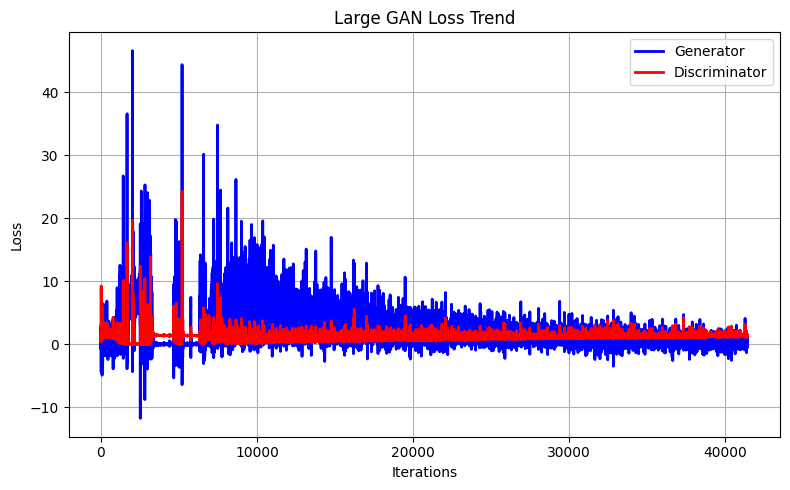

In [ ]:

iterations = list(range(1, len(losses_discriminator) + 1))

plt.figure(figsize=(8, 5))
plt.plot(iterations, losses_generator, label="Generator", color="blue", linewidth=2)
plt.plot(iterations, losses_discriminator, label="Discriminator", color="red", linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Large GAN Loss Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gan_large.save("gan_large.pth")

generator_large = generator
discriminator_large = discriminator

## Generate Music

Below are generated folders and 150 midi files for all 3 trained models.

In [ ]:
noise_dim = 512  # Noise vector size

def generate_noise(batch_size: int, device: torch.device) -> torch.Tensor:
    return torch.randn(batch_size, noise_dim, device=device)

def predict_sequences(generator: torch.nn.Module, n_samples: int, device: torch.device):
    noise_batch = generate_noise(n_samples, device)
    return generator(noise_batch).cpu().detach().numpy()

def generate_midi_files(generator: torch.nn.Module, n_samples: int, output_prefix: str, device: torch.device):
    # Generate normalized sequences
    normalized_outputs = predict_sequences(generator, n_samples, device)

    # Boundary calculation to map normalized values ​​to original tokens
    boundary = len(tokenizer) // 2
    token_sequences = [output * boundary + boundary for output in normalized_outputs]

    for i, sequence in enumerate(token_sequences):
        tokens = sequence.astype(np.int32)

        # Replace any out-of-vocabulary values
        tokens[tokens == len(tokenizer)] = 0

        try:
            decoded_midi = tokenizer.decode([tokens])
            file_path = f"{output_prefix}_{i}.mid"
            decoded_midi.dump_midi(file_path)
            print(f"MIDI generate: {file_path}")
        except Exception as e:
            print(f"Error generating MIDI for sample {i}: {e}")


In [ ]:

num_midi_files = 150

output_folder = "generated_mini"
output_prefix = f"{output_folder}/generated_midi"

os.makedirs(output_folder, exist_ok=True)

sample_normalized_outputs = predict_sequences(generator_mini, 2, device)
token_boundary = len(tokenizer) // 2
sample_token_sequences = [seq * token_boundary + token_boundary for seq in sample_normalized_outputs]

generate_midi_files(
    generator=generator_mini,
    n_samples=num_midi_files,
    output_prefix=output_prefix,
    device=device,
)


MIDI generate: generated_mini/generated_midi_0.mid
MIDI generate: generated_mini/generated_midi_1.mid
MIDI generate: generated_mini/generated_midi_2.mid
MIDI generate: generated_mini/generated_midi_3.mid
MIDI generate: generated_mini/generated_midi_4.mid
MIDI generate: generated_mini/generated_midi_5.mid
MIDI generate: generated_mini/generated_midi_6.mid
MIDI generate: generated_mini/generated_midi_7.mid
MIDI generate: generated_mini/generated_midi_8.mid
MIDI generate: generated_mini/generated_midi_9.mid
MIDI generate: generated_mini/generated_midi_10.mid
MIDI generate: generated_mini/generated_midi_11.mid
MIDI generate: generated_mini/generated_midi_12.mid
MIDI generate: generated_mini/generated_midi_13.mid
MIDI generate: generated_mini/generated_midi_14.mid
MIDI generate: generated_mini/generated_midi_15.mid
MIDI generate: generated_mini/generated_midi_16.mid
MIDI generate: generated_mini/generated_midi_17.mid
MIDI generate: generated_mini/generated_midi_18.mid
MIDI generate: generat

In [ ]:
num_midi_files = 150

output_folder = "generated_medium"
output_prefix = f"{output_folder}/generated_midi"

os.makedirs(output_folder, exist_ok=True)

sample_normalized_outputs = predict_sequences(generator_medium, 2, device)
token_boundary = len(tokenizer) // 2
sample_token_sequences = [seq * token_boundary + token_boundary for seq in sample_normalized_outputs]

generate_midi_files(
    generator=generator_medium,
    n_samples=num_midi_files,
    output_prefix=output_prefix,
    device=device,
)

MIDI generate: generated_medium/generated_midi_0.mid
MIDI generate: generated_medium/generated_midi_1.mid
MIDI generate: generated_medium/generated_midi_2.mid
MIDI generate: generated_medium/generated_midi_3.mid
MIDI generate: generated_medium/generated_midi_4.mid
MIDI generate: generated_medium/generated_midi_5.mid
MIDI generate: generated_medium/generated_midi_6.mid
MIDI generate: generated_medium/generated_midi_7.mid
MIDI generate: generated_medium/generated_midi_8.mid
MIDI generate: generated_medium/generated_midi_9.mid
MIDI generate: generated_medium/generated_midi_10.mid
MIDI generate: generated_medium/generated_midi_11.mid
MIDI generate: generated_medium/generated_midi_12.mid
MIDI generate: generated_medium/generated_midi_13.mid
MIDI generate: generated_medium/generated_midi_14.mid
MIDI generate: generated_medium/generated_midi_15.mid
MIDI generate: generated_medium/generated_midi_16.mid
MIDI generate: generated_medium/generated_midi_17.mid
MIDI generate: generated_medium/genera

In [ ]:
num_midi_files = 150

output_folder = "generated_large"
output_prefix = f"{output_folder}/generated_midi"

os.makedirs(output_folder, exist_ok=True)

sample_normalized_outputs = predict_sequences(generator_large, 2, device)
token_boundary = len(tokenizer) // 2
sample_token_sequences = [seq * token_boundary + token_boundary for seq in sample_normalized_outputs]

generate_midi_files(
    generator=generator_large,
    n_samples=num_midi_files,
    output_prefix=output_prefix,
    device=device,
)

MIDI generate: generated_large/generated_midi_0.mid
MIDI generate: generated_large/generated_midi_1.mid
MIDI generate: generated_large/generated_midi_2.mid
MIDI generate: generated_large/generated_midi_3.mid
MIDI generate: generated_large/generated_midi_4.mid
MIDI generate: generated_large/generated_midi_5.mid
MIDI generate: generated_large/generated_midi_6.mid
MIDI generate: generated_large/generated_midi_7.mid
MIDI generate: generated_large/generated_midi_8.mid
MIDI generate: generated_large/generated_midi_9.mid
MIDI generate: generated_large/generated_midi_10.mid
MIDI generate: generated_large/generated_midi_11.mid
MIDI generate: generated_large/generated_midi_12.mid
MIDI generate: generated_large/generated_midi_13.mid
MIDI generate: generated_large/generated_midi_14.mid
MIDI generate: generated_large/generated_midi_15.mid
MIDI generate: generated_large/generated_midi_16.mid
MIDI generate: generated_large/generated_midi_17.mid
MIDI generate: generated_large/generated_midi_18.mid
MID

In [ ]:
!zip -r genereted_mini.zip generated_mini
!zip -r genereted_medium.zip generated_medium
!zip -r genereted_large.zip generated_large

VALUTARE prestazioni

In [ ]:
!gdown --id 1I934mSmMq7MwPqA2t-S2vKIGX7gFxd0v
!gdown --id 1uA5BMMYpS-oDg21lasSkwqbG2528xJEc
!gdown --id 1z63W0kqQJUE_rrJ7QnSZxAi4yRf-zPCL

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1t9BCZUrk_Io0ayouCly-KPLmjSGy5bBP
To: /content/generetedMIDI.zip
100% 133k/133k [00:00<00:00, 71.2MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1I934mSmMq7MwPqA2t-S2vKIGX7gFxd0v
To: /content/genereted_large.zip
100% 184k/184k [00:00<00:00, 16.4MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: ht

In [ ]:
!unzip genereted_mini.zip
!unzip genereted_medium.zip
!unzip genereted_large.zip

Archive:  genereted_mini.zip
   creating: generated_mini/
  inflating: generated_mini/generated_midi_46.mid  
  inflating: generated_mini/generated_midi_64.mid  
  inflating: generated_mini/generated_midi_145.mid  
  inflating: generated_mini/generated_midi_31.mid  
  inflating: generated_mini/generated_midi_131.mid  
  inflating: generated_mini/generated_midi_137.mid  
  inflating: generated_mini/generated_midi_106.mid  
  inflating: generated_mini/generated_midi_142.mid  
  inflating: generated_mini/generated_midi_22.mid  
  inflating: generated_mini/generated_midi_50.mid  
  inflating: generated_mini/generated_midi_111.mid  
  inflating: generated_mini/generated_midi_103.mid  
  inflating: generated_mini/generated_midi_34.mid  
  inflating: generated_mini/generated_midi_109.mid  
  inflating: generated_mini/generated_midi_23.mid  
  inflating: generated_mini/generated_midi_96.mid  
  inflating: generated_mini/generated_midi_80.mid  
  inflating: generated_mini/generated_midi_58.mid 

In [ ]:
def pitch_count(notes):
    """
    notes: list of int (pitch values)
    """
    return len(notes)


def note_density(notes, total_duration_sec):
    """
    notes: list of notes
    total_duration_sec: duration of piece in seconds
    """
    return len(notes) / total_duration_sec if total_duration_sec > 0 else 0

def rote_memorization_frequency(notes, pattern_length=3):
    """
    Return average number of repetitions for note patterns of length `pattern_length`
    """
    patterns = [tuple(notes[i:i+pattern_length]) for i in range(len(notes)-pattern_length+1)]
    counts = Counter(patterns)
    repeated = [count for pattern, count in counts.items() if count > 1]
    return np.mean(repeated) if repeated else 0

def pitch_intervals(notes):
    """
    Returns average absolute pitch interval between consecutive notes
    """
    if len(notes) < 2:
        return 0
    intervals = [abs(notes[i] - notes[i-1]) for i in range(1, len(notes))]
    return np.mean(intervals)

def pitch_class_histogram(notes):
    """
    Returns normalized histogram over 12 pitch classes
    """
    hist = np.zeros(12)
    for pitch in notes:
        hist[pitch % 12] += 1
    total = np.sum(hist)
    return hist / total if total > 0 else hist


def extract_notes_from_midi(file_path):
    mid = mido.MidiFile(file_path)
    notes = []
    total_time = 0.0

    for track in mid.tracks:
        time_accum = 0
        for msg in track:
            time_accum += msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.append(msg.note)  # pitch MIDI
        total_time = max(total_time, time_accum * mid.ticks_per_beat)
    duration_sec = mid.length
    return notes, duration_sec


# --- WRAPPER FUNSION ---
def pitch_count_from_midi(file_path):
    notes, _ = extract_notes_from_midi(file_path)
    return pitch_count(notes)

def note_density_from_midi(file_path):
    notes, duration_sec = extract_notes_from_midi(file_path)
    return note_density(notes, duration_sec)

def rote_memorization_frequency_from_midi(file_path, pattern_length=3):
    notes, _ = extract_notes_from_midi(file_path)
    return rote_memorization_frequency(notes, pattern_length)

def pitch_intervals_from_midi(file_path):
    notes, _ = extract_notes_from_midi(file_path)
    return pitch_intervals(notes)

def pitch_class_histogram_from_midi(file_path):
    notes, _ = extract_notes_from_midi(file_path)
    return pitch_class_histogram(notes)


In [ ]:

def run_function_on_folder(folder_path, func):
    """
      Runs a function (MIDI wrapper) on all MIDI files in a folder.

      Parameters:
      folder_path (str): path to the MIDI folder
      func (callable): wrapper function that accepts a file_path

      Returns:
      np.ndarray: results for each MIDI file
    """
    results = []
    midi_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".mid", ".midi"))]

    for fname in midi_files:
        file_path = os.path.join(folder_path, fname)
        try:
            result = func(file_path)
            results.append(result)
        except Exception as e:
            print(f"Errore con {fname}: {e}")
            results.append(None)

    return np.array(results, dtype=object)


In [ ]:
def kld(p, q):
    """
    Kullback-Leibler Divergence between distributions p and q
    p, q: numpy arrays representing probability distributions
    """
    p = np.asarray(p, dtype=np.float64) + 1e-12
    q = np.asarray(q, dtype=np.float64) + 1e-12
    p /= p.sum()
    q /= q.sum()
    return np.sum(rel_entr(p, q))

def make_distribution(values, bins=50, range=None):
    hist, _ = np.histogram(values, bins=bins, range=range, density=False)
    hist = hist.astype(float)
    return hist / hist.sum() if hist.sum() > 0 else hist

def real_run_function_on_folder(real_folder):
    results = {}
    real_pc = run_function_on_folder(real_folder, pitch_count_from_midi)
    real_nd = run_function_on_folder(real_folder, note_density_from_midi)
    real_rm = run_function_on_folder(real_folder, rote_memorization_frequency_from_midi)
    real_pi = run_function_on_folder(real_folder, pitch_intervals_from_midi)
    real_hist = np.mean(run_function_on_folder(real_folder, pitch_class_histogram_from_midi), axis=0)

    results["pitch_count"] = real_pc
    results["note_density"] = real_nd
    results["rote_memorization_frequency"] = real_rm
    results["pitch_intervals"] = real_pi
    results["pitch_class_histogram"] = real_hist

    return results

def compare_folders_with_kld(real_result, generated_folder):
    results = {}

    gen_pc  = run_function_on_folder(generated_folder, pitch_count_from_midi)
    results["pitch_count"] = kld(make_distribution(real_result["pitch_count"]), make_distribution(gen_pc))

    gen_nd  = run_function_on_folder(generated_folder, note_density_from_midi)
    results["note_density"] = kld(make_distribution(real_result["note_density"]), make_distribution(gen_nd))

    gen_rm  = run_function_on_folder(generated_folder, rote_memorization_frequency_from_midi)
    results["rote_memorization_frequency"] = kld(make_distribution(real_result["rote_memorization_frequency"]), make_distribution(gen_rm))

    gen_pi  = run_function_on_folder(generated_folder, pitch_intervals_from_midi)
    results["pitch_intervals"] = kld(make_distribution(real_result["pitch_intervals"]), make_distribution(gen_pi))

    gen_hist  = np.mean(run_function_on_folder(generated_folder, pitch_class_histogram_from_midi), axis=0)
    results["pitch_class_histogram"] = kld(real_result["pitch_class_histogram"], gen_hist)

    return results


In [ ]:
generated_mini_folder = "/content/generated_mini"
generated_medium_folder = "/content/generated_medium"
generated_large_folder = "/content/generated_large"
real_folder = "/content/dataset_midi"

real_result = real_run_function_on_folder(real_folder)

results_mini = compare_folders_with_kld(real_result, generated_mini_folder)
results_medium = compare_folders_with_kld(real_result, generated_medium_folder)
results_large = compare_folders_with_kld(real_result, generated_large_folder)

print("Result mini:")
for key, value in results_mini.items():
    print(f"{key}: KLD = {value:.4f}")

print("Result medium:")
for key, value in results_medium.items():
    print(f"{key}: KLD = {value:.4f}")

print("Result large:")
for key, value in results_large.items():
    print(f"{key}: KLD = {value:.4f}")

Result mini:
pitch_count: KLD = 9.7003
note_density: KLD = 1.9253
rote_memorization_frequency: KLD = 24.6687
pitch_intervals: KLD = 2.2011
pitch_class_histogram: KLD = 0.0003
Result medium:
pitch_count: KLD = 6.1511
note_density: KLD = 13.4694
rote_memorization_frequency: KLD = 22.3020
pitch_intervals: KLD = 2.1593
pitch_class_histogram: KLD = 0.0011
Result large:
pitch_count: KLD = 4.4212
note_density: KLD = 1.8728
rote_memorization_frequency: KLD = 24.6687
pitch_intervals: KLD = 4.3031
pitch_class_histogram: KLD = 0.0008


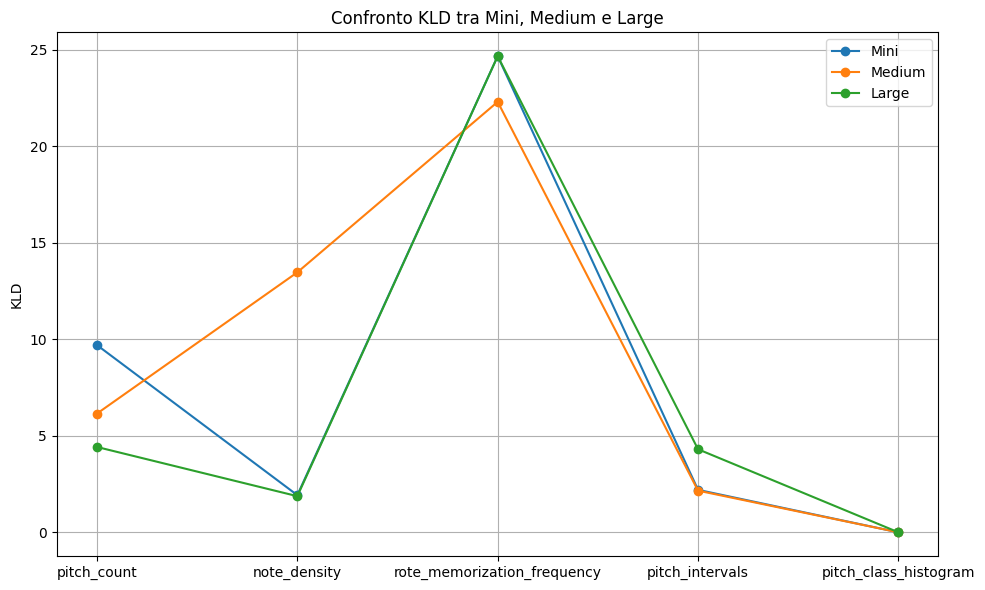

In [ ]:
metrics = list(results_mini.keys())
values_mini = list(results_mini.values())
values_medium = list(results_medium.values())
values_large = list(results_large.values())

plt.figure(figsize=(10,6))
plt.plot(metrics, values_mini, marker="o", label="Mini")
plt.plot(metrics, values_medium, marker="o", label="Medium")
plt.plot(metrics, values_large, marker="o", label="Large")

plt.ylabel("KLD")
plt.title("Confronto KLD tra Mini, Medium e Large")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()